# <center> Book Recommendations System - Baseline Model</center>
#### <center>**By: Mili Ketan Thakrar**</center>

<a id="TOC"></a> <br>
## Table of Contents
1. [Introduction](#intro)
2. [Importing Libraries and Custom Definitions](#import)
4. [Loading the Dataset](#loading)
5. [Data Dictionary](#dict)
6. [Popularity based](#popular)
7. [Logistic Regression - Baseline](#log)
   1. [Machine Lerning Pipeline](#pipeline)
   2. [Model Iteration](#iterate)
   3. [Evaluating Models](#eval1)
8. [Cosine Similarity](#cosine)
    1. [Cosine Similarity using Word Embeddings](#word)
10. [Conclusion and Next Steps](#conclusion)

<a id="intro"></a>
## Introduction

A book recommendation system is an intelligent application designed to help users discover books tailored to their interests and reading preferences. By analyzing user behavior, ratings, and book attributes, the system provides personalized suggestions, enhancing the reading experience and making it easier to find engaging and relevant books. This project aims to develop an efficient recommendation engine using advanced algorithms and data analysis techniques.

#### **Baseline Models**

In this notebook, we will focus on building and evaluating **baseline models** for our book recommendation system. Baseline models are simple, interpretable approaches that serve as a foundation for comparison with more advanced techniques in later phases. They provide a quick way to assess the quality of recommendations without requiring complex algorithms or extensive user interaction data.

We will implement three baseline approaches:

1. **Popularity-Based Recommendations**: A straightforward method that recommends the most popular books (e.g., highest-rated or most-read) to all users. While not personalized, this serves as a useful benchmark.
   
2. **Logistic Regression (Classification Baseline)**: A basic machine learning model that predicts whether a user will like a book based on its features such as title, publisher and more. This approach introduces personalization by leveraging book attributes.

3. **Content-Based Recommendations with word embeddings**: A method that uses semantic similarity between book descriptions to recommend similar books. By leveraging word embeddings and cosine similarity, this approach provides personalized recommendations based on the content of books.

By the end of this notebook, we aim to:
- Establish baseline performance metrics.
- Identify strengths and limitations of these methods.
- Set the stage for more advanced techniques.

<a id="import"></a>
## Importing Libraries 
[Back to Table of Contents](#TOC)

In [94]:
# Data Handling & Utilities
import pandas as pd
import numpy as np
from data_utils import (  # Custom utility functions
    import_csv, 
    generate_data_dictionary, 
    define_df_settings  
)

# Machine Learning Pipeline
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    FunctionTransformer, 
    LabelEncoder
)
from sklearn.decomposition import PCA, IncrementalPCA

# Model Training & Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Recommendation System
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt


# Progress Tracking
from tqdm import tqdm
tqdm.pandas()  # Enable pandas progress tracking

# Text Processing Utilities
import re  # Regular expressions

# Warning Configuration
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Pandas Display Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


<a id="loading"></a>
## Loading the Dataset
[Back to Table of Contents](#TOC)

In [77]:
# Loading the clean dataset 
df = import_csv('cleaned_data.csv')

Successfully imported data from cleaned_data.csv


In [78]:
df.head()

,ISBN,Title,Author,Ratings,Total_num_of_ratings,Avg_ratings,Avg_ratings_excluding_zero,Publisher,Year_Category,Publication_year,User_id,Age_Category,City,State,Country,Image_URL
0,1558746218,A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),Jack Canfield,0,56,3.89,7.79,Health Communications,1980-1999,1998,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1558746218.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,5,14,4.93,7.67,HarperFlamingo Canada,2000-2009,2001,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,0,3,5.00,7.50,HarperPerennial,1980-1999,1991,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,0,11,4.27,7.83,Farrar Straus Giroux,1980-1999,1999,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,7,3,4.67,7.00,River City Pub,1980-1999,1994,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1881320189.01.LZZZZZZZ.jpg


In [79]:
df.shape

(851505, 16)

<a id="dict"></a>
## Data Dictionary
[Back to Table of Contents](#TOC)

In [46]:
data_dict = generate_data_dictionary(df)
display(data_dict)

,Column Name,Data Type,Description,Unique Values,Missing Values,Value Range
0,ISBN,object,"International Standard Book Number, unique identifier for books",149831,0,N/A
1,Title,object,The title of the book,135563,0,N/A
2,Author,object,The name of the book's author,62110,0,N/A
3,Ratings,int64,"User's rating of the book, scale of 1-10",11,0,"(0, 10)"
4,Total_num_of_ratings,int64,Total number of ratings for the book,377,0,"(1, 2502)"
5,Avg_ratings,float64,Average rating score for the book,710,0,"(0.11, 10.0)"
6,Avg_ratings_excluding_zero,float64,Average rating score for the book excluding 0 values,418,0,"(1.0, 10.0)"
7,Publisher,object,The name of the book's publisher,11573,0,N/A
8,Year_Category,object,Categorized time period of publication,7,0,N/A
9,Publication_year,int64,The year the book was published,100,0,"(0, 2020)"


<a id="popular"></a>
## Popularity Based
[Back to Table of Contents](#TOC)

We are starting with a very basic recommendation model that relies solely on popularity to determine which books to recommend. This initial model does not incorporate any contextual information or user-specific knowledge and serves as a rudimentary baseline to help us get started with building a recommendation system.

To improve upon this simplistic approach, we are using a **weighted rating** method. This technique enhances the recommendations by combining an item's average rating with its popularity (i.e., the number of ratings). By doing so, it avoids the pitfalls of relying solely on either metric, ensuring a more balanced and meaningful ranking of items.

##### Why Weighted Rating is Better than Simple Popularity
1. **Reduces Outlier Influence**:  
   A single 5-star rating from one user won't disproportionately boost an item's ranking.

2. **Surfaces Quality Content**:  
   Books with consistently high ratings (e.g., 4.5 stars from 80 ratings) are prioritized over books with lower average ratings, even if they have a higher number of total ratings (e.g., 3.8 stars from 500 ratings).

3. **Dynamic Balancing**:  
   The model naturally adjusts as items receive more ratings, ensuring that newer books with fewer reviews still have a chance to compete fairly.

This weighted approach provides a more nuanced recommendation system while remaining simple enough to serve as an effective starting point for further development.

Let's look at the formula for the weighted rating below: 

**Weighted Rating formula**:
$$
\text{Weighted Rating} = \frac{v}{v + m} \cdot R + \frac{m}{v + m} \cdot C
$$

Where:

- R: Average rating of the book (Avg_ratings)
- v: Number of ratings for the book (Total_num_of_ratings)
- m: Minimum number of ratings required to be considered (e.g., the 80th percentile of Total_num_of_ratings)
- C: Mean average rating across all books

We will also be removing duplicate entries in our dataset so as to not get the same 5 or 10 book recommended to use and so that we actually get a varity of the top rated recommendations. Now let's apply the above to our dataset and find the most popular books: 

In [47]:
# Defining minimum number of ratings required (e.g., 80th percentile)
m = df['Total_num_of_ratings'].quantile(0.80)

# Calculating the mean average rating across all books
C = df['Avg_ratings'].mean()

# Filtering books that meet the minimum number of ratings
popular_books = df[df['Total_num_of_ratings'] >= m]

# Calculating Weighted Rating
def weighted_rating(x, m=m, C=C):
    v = x['Total_num_of_ratings']
    R = x['Avg_ratings']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [48]:
# creating a new column using the weighted ratings 
popular_books['Weighted_Rating'] = popular_books.apply(weighted_rating, axis=1)

# Removing duplicate entries based on 'Title'
popular_books = popular_books.drop_duplicates(subset='Title')

# Sorting books by Weighted Rating in descending order
popular_books = popular_books.sort_values('Weighted_Rating', ascending=False)

# Selecting Top 10 Books
top_10_books = popular_books[['Title', 'Author', 'Publisher', 'Weighted_Rating']].head(10)

print("Top 10 Popular Books:")
top_10_books

Top 10 Popular Books:


,Title,Author,Publisher,Weighted_Rating
369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,Scholastic,5.356822
367,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,Scholastic,5.292777
371,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,Scholastic,5.087346
368,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,Scholastic,5.003655
365,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,Scholastic,4.892268
1267,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,Tor Books,4.805739
615,The Little Prince,Antoine de Saint-ExupÃ©ry,Harcourt,4.776057
2842,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,Arthur A. Levine Books,4.665212
466,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",J. R. R. Tolkien,Houghton Mifflin Company,4.602030
4975,The Hobbit : The Enchanting Prelude to The Lord of the Rings,J.R.R. TOLKIEN,Del Rey,4.567724


Our initial popularity-based model highlights well-known books like the *Harry Potter* and *The Lord of the Rings* series, as these are objectively some of the most popular and globally recognized titles. However, this basic model lacks context about other features and provides the same recommendations (e.g., the top 10 books) to all users, making it ineffective for personalized recommendations.

To address this limitation and gain a better understanding of which features are useful for building a recommender system, we will develop a more advanced baseline model using **logistic regression**. This approach will allow us to incorporate additional features and move beyond simple popularity, enabling more tailored and meaningful recommendations for users.

<a id="log"></a>
## Logistic Regression - Baseline
[Back to Table of Contents](#TOC)

To build a more robust baseline for our book recommendation system, we will use a logistic regression model. This model will help us better understand which features are most influential in predicting user preferences. Logistic regression is particularly useful because it provides interpretable insights into feature importance while being computationally efficient. By analyzing the relationships between features and user ratings, we can identify patterns that will guide the development of more advanced recommendation algorithms.

Using this approach, we aim to create a baseline model that not only predicts user ratings but also provides insights into which features (e.g. author popularity, or average rating) are most impactful. This will serve as a foundation for refining our recommendation system and incorporating more sophisticated techniques in the future.

In [49]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns ")

The dataset has 851505 rows and 16 columns 


In [50]:
# Count the total number of unique authors
total_unique_authors = df['Author'].nunique()

print(f"Total number of unique authors: {total_unique_authors}")

Total number of unique authors: 62110


For this model, we will categorize user ratings into 2 distinct classes: recommend or not recommend. This categorization simplifies the problem and allows us to predict the likelihood of a book falling into one of these categories based on its features. The categorization function is defined as follows:

In [51]:
# definition for encoding the rating into catergories for logistic model 
def categorize_rating_binary(rating):
    if rating < 4:  #Very Bad, Bad, Average
        return "Not Recommended"
    else:  #Good and Excellent
        return "Recommended"

# Apply the function to create a new categorical column
df["Rating_Category"] = df["Ratings"].apply(categorize_rating_binary)

We will map the "Rating_Category" column, assigning a value of 1 if the rating is "Recommended" and 0 if it's "Not Recommended." This conversion to a binary numerical representation is crucial because most machine learning algorithms require numerical input, enabling us to train a model to predict whether a book will be well-received based on its features.

In [52]:
# numercial transilation of the ratings 
df["Rating_Encoded"] = df["Rating_Category"].apply(lambda x: 1 if x == "Recommended" else 0)

In [53]:
df.head()

,ISBN,Title,Author,Ratings,Total_num_of_ratings,Avg_ratings,Avg_ratings_excluding_zero,Publisher,Year_Category,Publication_year,User_id,Age_Category,City,State,Country,Image_URL,Rating_Category,Rating_Encoded
0,1558746218,A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),Jack Canfield,0,56,3.89,7.79,Health Communications,1980-1999,1998,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1558746218.01.LZZZZZZZ.jpg,Not Recommended,0
1,0002005018,Clara Callan,Richard Bruce Wright,5,14,4.93,7.67,HarperFlamingo Canada,2000-2009,2001,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,Recommended,1
2,0060973129,Decision in Normandy,Carlo D'Este,0,3,5.00,7.50,HarperPerennial,1980-1999,1991,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,Not Recommended,0
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,0,11,4.27,7.83,Farrar Straus Giroux,1980-1999,1999,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,Not Recommended,0
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,7,3,4.67,7.00,River City Pub,1980-1999,1994,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1881320189.01.LZZZZZZZ.jpg,Recommended,1


Now we see that we have our data for the ratings into numerical form, but we still have some columns that are non-numerial such as title, author, publisher, year category and Publisher category. We will encode these columns all at once using a column tranformer so that we do not have to do each step individually.

<a id="pipeline"></a>
### Machine Learning Pipeline

Before diving into the implementation, let’s discuss the rationale behind our approach and the choices made for preprocessing, modeling, and evaluation.

##### **Why Perform Train-Test Split First?**
The first and most critical step is splitting the dataset into **training** and **testing** subsets. This ensures that we can evaluate the model’s performance on unseen data and avoid overfitting. By splitting the data before any preprocessing:
- **Preprocessing Integrity**: Steps like TF-IDF vectorization and scaling are fit only on the training set. The test set remains untouched during preprocessing to prevent information leakage.
- **Fair Evaluation**: Keeping the test set separate ensures unbiased evaluation metrics, as the model is tested on data it has never seen before.
- **Robustness**: Train-test splitting helps us assess how well the model generalizes to new data, which is crucial for building reliable recommendation systems.


##### **Why This Approach?**
In this project, we aim to build a book recommendation system that integrates multiple types of features—categorical, text-based, and numerical. To process these diverse features effectively, we employ a combination of tailored techniques:
- **Categorical Features**: These are transformed using one-hot encoding to represent them numerically in a way that machine learning models can interpret.
- **Text Features**: For text columns like book titles and author names, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization with lemmatization to extract meaningful features while reducing noise.
- **Numerical Features**: Numerical columns are scaled using standard scaling to normalize their values and improve model performance.

This comprehensive approach ensures that each feature type is handled appropriately, enabling us to build a robust recommendation system.

##### **Why Use TF-IDF Instead of Count Vectorizer?**
While both TF-IDF and Count Vectorizer are common text feature extraction methods, TF-IDF is better suited for this task due to its ability to capture the importance of words in context:
1. **Focus on Informative Words**: TF-IDF assigns higher importance to unique words in a document while reducing the weight of common words across all documents. This helps highlight distinctive terms in book titles or author names that are more relevant for recommendations.
2. **Noise Reduction**: Unlike Count Vectorizer, which simply counts word occurrences, TF-IDF adjusts for word frequency across the dataset. This prevents frequent but less meaningful words (e.g., "book", "author") from dominating the feature space.
3. **Contextual Representation**: By capturing term importance relative to its context, TF-IDF provides a richer representation of text data. This makes it more effective for tasks like book recommendations where subtle differences in text matter.


##### **Why Use Lemmatization?**
Lemmatization reduces words to their base form (e.g., "running" → "run"), ensuring that variations of the same word are treated as a single feature. This improves:
- **Consistency**: Reduces redundancy in the feature space by treating similar words as one.
- **Feature Quality**: Helps focus on meaningful terms rather than their grammatical variations.


By combining these preprocessing techniques into a pipeline, we streamline the workflow while ensuring that each feature type is processed correctly. This approach not only simplifies implementation but also allows us to build a robust baseline model capable of extracting meaningful insights from diverse data types.

Let's begin this proccess: 

In [54]:
# Splitting data into train and set 
X = df.drop(["Ratings", "Image_URL", "User_id", "ISBN", "City", "Publication_year", "Rating_Category", "Rating_Encoded"], axis=1)  
y = df["Rating_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # save the teain and test in saperate csv and read from there 

**Explanation of Removing Columns:**

- **ISBN**: This column is a unique identifier for books and does not provide meaningful information for modeling. Since features like Title, Author, and other book-related attributes are already included, ISBN adds no additional value.

- **User_id**: This column uniquely identifies users but does not contribute directly to predicting ratings unless for when we are building a personalized recommendation system (e.g., collaborative filtering). In this case, demographic features (like Age_Category, Country, etc.) already capture user-related information.

Other Columns (City, Publication_year):

- **City**: is too granular and its information is already captured by a broader feature of Country.

- **Publication_year**: is already transformed into a meaningful feature Year_Category, and hence we are dropping the raw column.


In [55]:
print(f"X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print(f"y_train has {y_train.shape[0]} rows")
print(f"y_test has {y_test.shape[0]} rows")

X_train has 681204 rows and 10 columns
X_test has 170301 rows and 10 columns
y_train has 681204 rows
y_test has 170301 rows


In [56]:
# Defining stop words
stop_words = set(stopwords.words('english'))

# Customing tokenizer with lemmatization
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc.lower())  # Tokenize and convert to lowercase
        return [self.lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

# Defining categorical and text columns
categorical_cols = ["Publisher", "Year_Category", "Age_Category", "State", "Country"]
text_cols = ["Title", "Author"]
numerical_cols = ["Total_num_of_ratings", "Avg_ratings", "Avg_ratings_excluding_zero"]

# Creating ColumnTransformer with lemmatization in TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("tfidf_title", TfidfVectorizer(
            tokenizer=LemmaTokenizer(),  # Use custom lemmatizing tokenizer
            min_df=2,  # Ignore terms appearing in fewer than 2 documents
            ngram_range=(1, 2)),  # Include unigrams and bigrams
         "Title"),
        ("tfidf_author", TfidfVectorizer(
            tokenizer=LemmaTokenizer(), 
            min_df=2,
            #max_df=0.8,
            ngram_range=(1, 1)), 
         "Author"),
        ("scaler", StandardScaler(), numerical_cols), # Scale numerical columns only
    ],
    remainder="passthrough"  # Keep numerical columns unchanged
)

In [57]:
# Creating pipeline with TF-IDF and Logistic Regression
pipeline1 = Pipeline([
    ("preprocessor", preprocessor),  # Apply TF-IDF transformations
    ("classifier", LogisticRegression(random_state=40))  # Logistic Regression model
])

# Fitting the pipeline on training data
pipeline1.fit(X_train, y_train)

# Predicting on training data
y_train_pred = pipeline1.predict(X_train)
train_accuracy_log_model1 = accuracy_score(y_train, y_train_pred)

# Predicting on test data
y_test_pred = pipeline1.predict(X_test)
test_accuracy_log_model1 = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy_log_model1}")
print(f"Test Accuracy: {test_accuracy_log_model1}")

Train Accuracy: 0.6829055613296457
Test Accuracy: 0.6674241490067586


In [58]:
# Initialize an empty dictionary to store model scores
model_scores = {}

# Add Logistic Regression scores to the dictionary
model_scores["Logistic Regression"] = {
    "Train Accuracy": train_accuracy_log_model1,
    "Test Accuracy": test_accuracy_log_model1
}

At this stage, we observe relatively low train and test accuracy scores, which is expected since this is a baseline model. We have not yet performed hyperparameter tuning or feature selection. Instead, we simply included all available features and trained logistic regression model on the entire dataset.

Despite the modest performance, this baseline model provides a starting point for understanding the data and identifying areas for improvement. Next, we will analyze the model to examine the importance of individual features and their effects on the target variable. This analysis will help us gain insights into which features contribute most to the predictions and guide us in refining the model further.

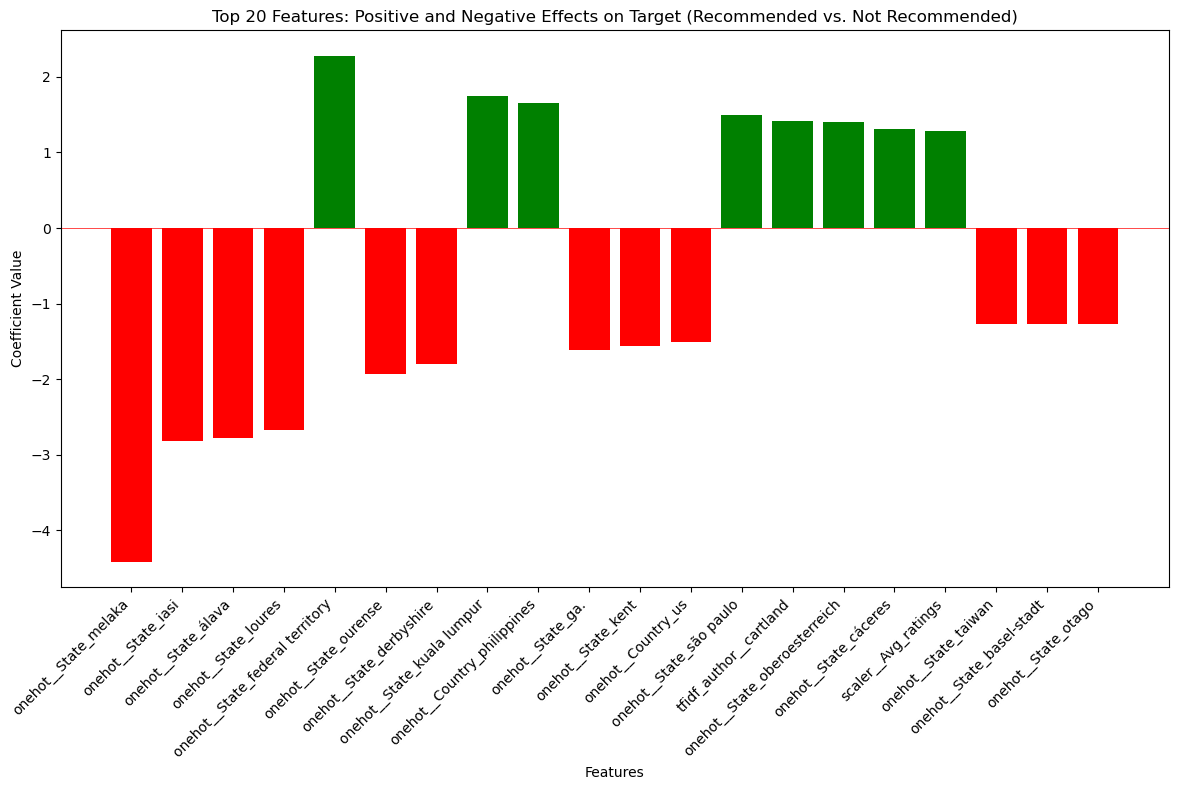

In [59]:
# 1. Extract Coefficients and Feature Names
logistic_model = pipeline1.named_steps['classifier']  # Access the LogisticRegression estimator
coefficients = logistic_model.coef_[0]  # Extract the coefficients
feature_names = pipeline1.named_steps['preprocessor'].get_feature_names_out()  # Get feature names from preprocessor

# 2. Create a DataFrame for Easier Handling
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# 3. Sort by Absolute Coefficient Value (Magnitude)
feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

# 4. Select Top N Features
top_n = 20  # Number of top features to display
top_features = feature_importance.head(top_n)

# 5. Create the Plot
plt.figure(figsize=(12, 8))
plt.bar(top_features['feature'], top_features['coefficient'], color=np.where(top_features['coefficient'] > 0, 'green', 'red'))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(f'Top {top_n} Features: Positive and Negative Effects on Target (Recommended vs. Not Recommended)')
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)  # Add a horizontal line at y=0
plt.tight_layout()
plt.show()

The above visualizes the top 20 features influencing our logistic regression model's binary classification of books into "Recommended" or "Not Recommended" categories, let's delve into a more detailed explanation:

**Overall Interpretation**

The plot presents a visual representation of the features with the most significant influence on the model's prediction. The bars indicate the strength and direction (positive or negative) of each feature's impact. The goal is to understand which factors contribute to a book being classified as "Recommended" versus "Not Recommended" based on the model's learned coefficients.

*   **Feature Type Diversity:** The top features include geographic indicators (`onehot_State_*`, `onehot_Country_*`), the average rating (`scaler_Avg_ratings`), and the author (`tfidf_author_cartland`).

**Individual Feature Analysis**

*   **Strong Negative Influence: `onehot_State_melaka`:** A large negative coefficient indicates that books associated with the state of "Melaka" are strongly disfavored by the model (i.e., they are more likely to be classified as "Not Recommended"). The prominence of this feature is questionable.

*   **Other Negative State Influences:** Several other state-level features (`onehot_State_iasi`, `onehot_State_alava`, etc.) also exhibit negative coefficients, suggesting that books from these regions are less likely to be "Recommended" according to the model. This overall pattern suggests that we're overfitting our model with state data.

*   **Potentially Problematic Geographic Indicators:** The presence of geographic indicators, while potentially capturing some cultural or regional preferences, is too broad for recommendation purposes. People in these countries likely enjoy and dislike a diverse collection of books, so this will not translate into a specific recommendation strategy.

*   **Positive Influence: `tfidf_author_cartland`:** The positive coefficient suggests that the tfidf-transformed features for "Cartland" are associated with books that are more likely to be "Recommended".

*   **Positive Influence: `scaler_Avg_ratings`:** As anticipated, a higher average rating positively influences the likelihood of a book being "Recommended." This validates the model and implies that, on average, highly-rated books are more likely to be favored.

**Critical Assessment**

*   **Model Limitations:** While the model identifies features that correlate with the target variable, it provides limited insight into *why* these correlations exist. Are there specific attributes of books from certain states that cause them to be less popular? Without further investigation, it's difficult to determine the underlying factors.

**Next Steps and Implications**

1.  **Shift to Content-Based Recommendations:** Given the limitations of the current model, the next logical step is to focus on a content-based recommendation system that leverages book titles, author, and potentially publisher to identify similar books.
2.  **Re-evaluate Feature Selection:** When moving forward, we will consider what value is added to the overall system. For example, is a state really beneficial?

In summary, while the logistic regression identifies influential features, the lack of clear interpretability and actionable insights necessitates a shift toward a content-based recommendation approach that can provide more relevant and personalized recommendations.

<a id="eval1"></a>
### Evaluating Models

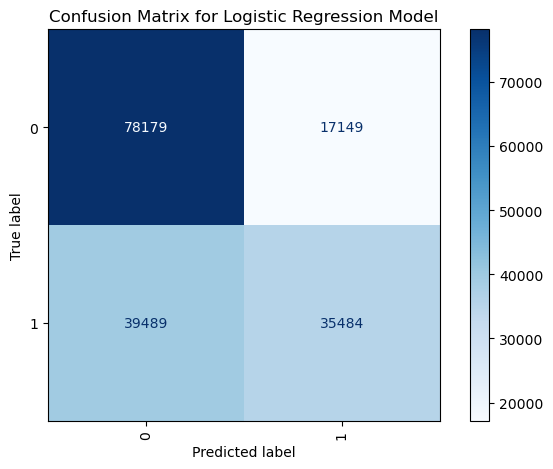

In [61]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, pipeline1.predict(X_test))

# Creating a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline1.named_steps['classifier'].classes_)

#Plotting the confusion matrix with desired formatting
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='.0f')

plt.title('Confusion Matrix for Logistic Regression Model'
plt.tight_layout()
plt.show()

In [66]:
# Accessing individual values from the matrix:
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 78179
False Positives: 17149
False Negatives: 39489
True Positives: 35484


#### Model Evaluation Analysis

**Precision** measures how often the model's positive predictions ("recommend") are correct:  
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{35,484}{35,484 + 17,149} \approx 0.674 $$  
This means **67.4% of "recommend" predictions were correct**.

**Recall** measures how well the model identifies all actual positives:  
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{35,484}{35,484 + 39,489} \approx 0.473 $$  
This indicates **47.3% of actual "recommend" cases were correctly identified**.

- **Specificity**:  
  $$ \frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{78,179}{78,179 + 17,149} = 82.0\% $$  
  *Interpretation*: **82% of bad books are correctly filtered out** (18% slip into recommendations).  

- **False Positive Rate**:  
  $$ \frac{\text{FP}}{\text{FP} + \text{TN}} = \frac{17,149}{17,149 + 78,179} = 18.0\% $$  
  *Interpretation*: **1 in 5 bad books are mistakenly recommended**.  

- **False Negative Rate**:  
  $$ \frac{\text{FN}}{\text{FN} + \text{TP}} = \frac{39,489}{39,489 + 35,484} = 52.7\% $$  
  *Interpretation*: **More than half of good books are never shown to users**.

  
**Interpretation**  
- **Precision (67.4%)**: Moderate reliability in recommendations, but 32.6% of "recommend" predictions were false alarms.  
- **Recall (47.3%)**: Nearly half of good books were missed by the model, indicating poor coverage of positive cases.  
- **Tradeoff**: The model prioritizes reducing false positives (higher precision) at the expense of missing many true positives (lower recall)

In [63]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.82      0.73     95328
           1       0.67      0.47      0.56     74973

    accuracy                           0.67    170301
   macro avg       0.67      0.65      0.65    170301
weighted avg       0.67      0.67      0.66    170301



#### **What F1 Score Represents**
The F1 score is the **harmonic mean of precision and recall**, designed to balance:
- **Precision**: Avoid recommending bad books (minimize false positives).  
- **Recall**: Surface most good books (minimize false negatives).  

For our model:  
| Class | Precision | Recall | F1-Score | Interpretation |  
|-------|-----------|--------|----------|-----------------|  
| **0 (Bad)** | 0.66 | 0.82 | **0.73** | Better balance - prioritizes filtering bad books effectively. |  
| **1 (Good)** | 0.67 | 0.47 | **0.56** | Poor balance - struggles to recommend good books reliably. |  


#### **Why F1 Matters More Than Accuracy Here**
- **Accuracy (67%)**: Misleading due to class imbalance (95,328 "bad" vs. 74,973 "good" books).  
- **F1-Score**:  
  - **Class 0 (0.73)**: Strong performance at filtering bad books.  
  - **Class 1 (0.56)**: Critical weakness in recommending good books.  

**Key Insight**: our model **prioritizes avoiding bad recommendations** (high Class 0 F1) over **surfacing good books** (low Class 1 F1).


#### **Business Impact of F1 Scores**
- **High Class 0 F1 (0.73)**:  
  - **Benefit**: Users see fewer bad books (trust preserved).  
  - **Cost**: Over-filtering may hide marginally "good" books.  
- **Low Class 1 F1 (0.56)**:  
  - **Risk**: Users miss 53% of good books (reduced engagement/revenue).  
  - **Example**: If our catalog has 10,000 good books, **5,300 never get recommended**.

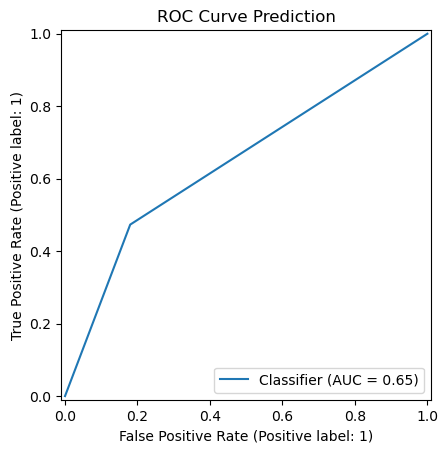

In [65]:
# ploting our ROC AUC curve 
RocCurveDisplay.from_predictions(y_test, y_test_pred)
plt.title("ROC Curve Prediction")
plt.show()

The above graph shows an ROC (Receiver Operating Characteristic) curve for our book recommendation model.

*   **ROC Curve**: Plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings.
*   **AUC (Area Under the Curve) = 0.65**: Quantifies the overall ability of the model to discriminate between positive (good books) and negative (bad books) classes.
    *   An AUC of 0.65 suggests the model has a **fairly weak** ability to distinguish between good and bad books.

*   **Shape of the Curve**:
    *   The curve is above the diagonal, indicating some level of skill above random guessing.
    *   The curve's shape is not ideal; a better model would have a curve that rises more steeply toward the top-left corner, indicating high true positive rates and low false positive rates simultaneously.

In summary, the ROC curve and AUC value suggest that our model has a limited ability to effectively distinguish between good and bad books, indicating room for improvement.

#### Summary 

Based on our model evaluation, which included analysis of coefficient impact and ROC AUC score (0.65), the logistic regression model demonstrates limited effectiveness in accurately predicting 'good' versus 'bad' books. Low recall coupled with the ROC AUC score suggest that while the model captures a large portion of the 'good' books, its overall discriminatory power is weak.

Furthermore, the model's reliance on state and country-related coefficients, rather than features directly relevant to book content, hinders its performance as a recommender system. As a result, it misses many opportunities to recommend truly 'good' books.

While further hyperparameter tuning may yield incremental improvements, the fundamental limitations of logistic regression for this task necessitate a shift in approach. Specifically, the model fails to account for critical factors such as author or genre similarity.

To address this, our next step involves leveraging word embeddings from a pre-trained Gensim model and applying cosine similarity to these vectors. By calculating the similarity between book titles, we aim to develop a recommender system that provides the top 5 most similar books based on semantic content. This approach will enable us to generate recommendations that are more closely aligned with readers' preferences, moving beyond demographic factors like location and age.

<a id="cosine"></a>
## Cosine Similarity
[Back to Table of Contents](#TOC)

**Current Model Limitations**  
The logistic regression approach provides limited insight into improving predictions, primarily focusing on location-based features that may influence user preferences. Its low recall score indicates significant gaps in capturing relevant recommendations, particularly for users with diverse reading histories. While hyperparameter tuning could enhance performance, this model fundamentally misaligns with our project goal: **personalized recommendations based on reading preferences**, not geographic factors.

**Proposed Solution: Content-Based Filtering with GloVe Embeddings**  
To prioritize textual content (titles/authors) and thematic relevance, we will implement a **content-based recommendation system** leveraging **GloVe embeddings**. Here's why this approach excels:  

#### Why GloVe?  
GloVe (Global Vectors for Word Representation) captures **semantic relationships** and **thematic patterns** across large text corpora. By converting titles and authors into semantic vectors, we can quantify similarities between books based on their *thematic essence* rather than surface-level keywords.  

#### Implementation Steps  
1. **Text Preprocessing**  
   - Convert titles/authors to lowercase  
   - Handle edge cases (e.g., "Harry Potter & the Philosopher's Stone" → "harry potter the philosophers stone")  

2. **Vectorization Process**  
   - Use a **pretrained GloVe model** (e.g., 300-dimensional vectors trained on Wikipedia)  
   - For each book title/author:  
     - Split text into tokens  
     - Retrieve GloVe vectors for each token  
     - Compute **mean vector** across all tokens to represent the entire title/author  

3. **Similarity Scoring**  
   - Calculate **cosine similarity** between the mean vectors of all book pairs  
   - For any given book, retrieve the **top 5 most similar books** based on cosine scores  

**Advantages Over Logistic Regression**  
- **Thematic Relevance**: Identifies books with similar narrative themes (e.g., "space opera" → "Dune" and "Foundation")  
- **Semantic Awareness**: Recognizes author styles (e.g., Margaret Atwood's dystopian works vs. J.K. Rowling's fantasy)  
- **Scalability**: Easily incorporates additional textual features (genres, descriptions) in future iterations  

**Next Phase: Hybrid Approach**  
After establishing this baseline, we will integrate **collaborative filtering** to account for user behavior patterns. This hybrid system will:  
1. Use content-based filtering for cold-start recommendations (new users/books)  
2. Apply collaborative filtering to refine suggestions based on user interaction data  
3. Balance personalization ("users like you enjoyed...") with thematic relevance ("similar to your favorite books...")  

This approach ensures recommendations are both **thematically coherent** and **personally relevant**, addressing the critical shortcomings of our initial model.

Let's take a look at implementing the above workflow. 

<a id="word"></a>
### Cosine Similarity with Word Embeddings

In [72]:
# Load Model 
glove_model = KeyedVectors.load_word2vec_format("glove.gensim.txt", binary=False)

# Step 1: Create unique title-author entries
books_df = df[['Author', 'Title']].drop_duplicates()

# Step 2: Combine title and author for vectorization
books_df['Title_Author'] = books_df['Title'] + ' by ' + books_df['Author']

# Step 3: Vectorize the composite field
def get_title_vector(text, model):
    words = text.lower().split()
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

books_df['Title_Vector'] = books_df['Title_Author'].progress_apply(
    lambda x: get_title_vector(x, glove_model)
)

# Step 4: Update similarity function
def get_similar_books(query_title, df, model, n=5):
    query_vec = get_title_vector(query_title, model).reshape(1, -1)
    title_vectors = np.vstack(df['Title_Vector'].values)
    df['Cosine_Similarity'] = cosine_similarity(query_vec, title_vectors).flatten()
    return df.sort_values('Cosine_Similarity', ascending=False)

# Step 5: Modified display function
def show_recommendations(query, n=5):
    results = get_similar_books(query, books_df, glove_model, n)
    return results[['Title', 'Author', 'Cosine_Similarity']].drop_duplicates('Title').head(n).style.hide(axis="index")

# Batch testing
queries = ["The Lord of the Rings", "Pride and Prejudice", "Science Fiction", "Harry Potter"]
for q in queries:
    print(f"\nTop 5 similar to '{q}':")
    display(show_recommendations(q))


100%|████████████████████████████████| 139637/139637 [00:01<00:00, 86940.75it/s]



Top 5 similar to 'The Lord of the Rings':


Title,Author,Cosine_Similarity
The Lord of the Rings: The QPB Companion to the Lord of the Rings (The Companion to the Lord of the Rings),J.R.R. Tolkien,0.974793
The Return of the King (The Lord of the Rings Part 3),J.R.R. Tolkien,0.966652
The Fellowship of the Ring Insiders' Guide (The Lord of the Rings Movie Tie-In),Brian Sibley,0.959634
"The Fellowship of the Ring: Being the First Part of the Lord of the Rings (The Lord of the Rings / By J.R.R. Tolkien, Pt. 1)",J. R. R. Tolkien,0.959360
Finding God in the Lord of the Rings,Kurt Bruner,0.958562



Top 5 similar to 'Pride and Prejudice':


Title,Author,Cosine_Similarity
Pride and Prejudice (Intermediate Level),Margaret Tarner,0.902205
Pride and Prejudice (World's Classics),Jane Austen,0.880312
Pride and Prejudice (Penguin Classics),Jane Austen,0.880312
Pride and Prejudice,Jane Austen,0.880312
Pride and Prejudice (Oxford World's Classics),Jane Austen,0.880312



Top 5 similar to 'Science Fiction':


Title,Author,Cosine_Similarity
Pictorial History of Science Fiction Films,Jeff Rovin,0.855772
Microcosmic Tales: 100 Wondrous Science Fiction Short-Short Stories,Asimov Isaac,0.855272
Writing Science Fiction and Fantasy (Self-Counsel Writing),Crawford Kilian,0.850029
Writing Science Fiction and Fantasy,Crawford Kilian,0.850029
Science Fiction,John Clute,0.843407



Top 5 similar to 'Harry Potter':


Title,Author,Cosine_Similarity
Harry Potter Hardcover Box Set (Books 1-4),J. K. Rowling,0.845769
Harry Potter Paperback Boxed Set (Books 1-4),J. K. Rowling,0.844517
Harry Potter E il Prigioniero D'Azkaban,J. K. Rowling,0.842181
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,0.836430
Harry Potter and the Prisoner of Azkaban (Harry Potter (Paperback)),J. K. Rowling,0.822120


After reviewing the workflow described above, we identified a few issues in our recommendation model. While the model performs well in suggesting books with similar titles and authors, the merging of user ratings with the dataset introduced multiple editions and versions of the same book.

For example, when searching for books similar to Harry Potter, the model successfully recommends related titles. However, due to different users rating various editions (e.g., box sets or reprints), we often receive multiple recommendations for essentially the same book. While we do get relevant suggestions like Harry Potter and the Prisoner of Azkaban, the repetition of different versions dilutes the recommendation quality.

To improve the model, we should refine the way we handle duplicate editions and focus on providing more meaningful, distinct recommendations. This will help users more easily discover their next read if they enjoyed a book like Harry Potter.

Let's look at another iternation of the model that might be better at handeling these duplicated values.

### Model Iteration

In this step, we are making a few key improvements to clean the data and enhance our recommendation model.

First, we are using regular expressions to remove any text within brackets in the book titles. This helps standardize titles and avoid variations caused by edition or format details. We are also ensuring that titles contain only English characters, which prevents random or incorrectly entered titles from appearing in our recommendations. Since the majority of our reader base is from the U.S., we can reasonably assume users prefer recommendations for English-language books.

Additionally, instead of simply dropping duplicate titles and authors, we are now identifying duplicated titles and keeping only the highest-rated version of each. This ensures we retain the most relevant and highest-quality recommendations without losing important titles.

Let's see if these improvements help our model generate more accurate and useful book suggestions.

In [93]:
# Load Model
glove_model = KeyedVectors.load_word2vec_format("glove.gensim.txt", binary=False)

# Step 1: Clean and prepare data
def clean_text(text):
    """Lowercase text and remove content within brackets"""
    text = re.sub(r'\([^)]*\)', '', text)  # Remove parentheses content
    text = re.sub(r'\[.*?\]', '', text)    # Remove square brackets content
    text = re.sub(r'\{.*?\}', '', text)    # Remove curly braces content
    return text.lower().strip()

def is_english(text):
    """Check if text contains only English characters and common punctuation"""
    return bool(re.match(r'^[a-zA-Z0-9\s.,!?\'"-]+$', text))

# Load data with ratings
books_df = df[['Author', 'Title', 'Avg_ratings']].copy()

# Clean text fields
books_df['Title'] = books_df['Title'].apply(clean_text)
books_df['Author'] = books_df['Author'].apply(clean_text)

# Filter English titles
books_df = books_df[books_df['Title'].apply(is_english)].copy()

# Handle duplicates - keep highest rated version per title
books_df = books_df.sort_values('Avg_ratings', ascending=False)
books_df = books_df.drop_duplicates('Title', keep='first')

# Create unique title-author entries
books_df = books_df.drop_duplicates(['Title', 'Author'])

# Combine cleaned fields
books_df['Title_Author'] = books_df['Title'] + ' by ' + books_df['Author']

# Step 2: Vectorization
def get_title_vector(text, model):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

books_df['Title_Vector'] = books_df['Title_Author'].progress_apply(
    lambda x: get_title_vector(x, glove_model)
)

# Step 3: Similarity functions
def get_similar_books(query_title, df, model):
    query_cleaned = clean_text(query_title)
    query_vec = get_title_vector(query_cleaned + ' by ', model).reshape(1, -1)
    title_vectors = np.vstack(df['Title_Vector'].values)
    df['Cosine_Similarity'] = cosine_similarity(query_vec, title_vectors).flatten()
    return df.sort_values('Cosine_Similarity', ascending=False)

def show_recommendations(query, n=10):
    results = get_similar_books(query, books_df, glove_model)
    return results[['Title', 'Author', 'Cosine_Similarity', 'Avg_ratings']].head(n).style.hide(axis="index")

# Batch testing
queries = ["The Lord of the Rings", "Science Fiction", "Harry Potter"]
for q in queries:
    print(f"\nTop 10 similar to '{q}':")
    display(show_recommendations(q))


100%|██████████████████████████████████| 80206/80206 [00:00<00:00, 89749.51it/s]



Top 10 similar to 'The Lord of the Rings':


Title,Author,Cosine_Similarity,Avg_ratings
lord of the rings in german,tolkien,0.966414,8.750000
finding god in the lord of the rings,kurt d. bruner,0.963144,4.170000
the rough guide to the lord of the rings,paul simpson,0.962443,8.500000
the lord of the rings and the hobbit,gene b. hardy,0.959634,4.330000
the lord of the rings oracle,terry donaldson,0.955918,9.000000
the sword of the land,noel-anne brennan,0.954703,4.750000
the eyes of the dragon,stephen king,0.954134,4.180000
the lord of the rings official movie guide,brian sibley,0.953240,5.000000
the practice of the presence of god,lawrence,0.953049,10.000000
the drawing of the three,stephen king,0.952729,4.130000



Top 10 similar to 'Science Fiction':


Title,Author,Cosine_Similarity,Avg_ratings
the science in science fiction,peter nicholls,0.937533,7.330000
writing science fiction and fantasy,crawford kilian,0.936976,5.000000
pictorial history of science fiction films,jeff rovin,0.936361,8.000000
the science fiction fantasy film handbook,alan frank,0.935063,3.500000
science fiction,john clute,0.932938,10.000000
the encyclopedia of science fiction,john clute,0.924817,10.000000
connoisseur's science fiction,t. boardman,0.923626,3.500000
modern masterpieces of science fiction,s. moskowitz,0.921226,10.000000
the encyclopedia of tv science fiction,roger fulton,0.914421,10.000000
sternenkadett nick seafort. science fiction roman.,david feintuch,0.913996,10.000000



Top 10 similar to 'Harry Potter':


Title,Author,Cosine_Similarity,Avg_ratings
harry potter and the sorcerer's stone,j. k. rowling,0.930866,10.000000
blackeyes,dennis potter,0.928368,3.000000
harry potter and the philosopher's stone,j.k. rowling,0.926405,5.750000
augenstern. roman.,harry mulisch,0.924836,7.000000
harry potter hardcover box set,j. k. rowling,0.923882,5.000000
harry potter and the prisoner of azkaban,j. k. rowling,0.918765,5.850000
harry potter and the goblet of fire,j. k. rowling,0.916542,10.000000
harry potter paperback boxed set,j. k. rowling,0.911517,5.000000
moneymakers.,harry bingham,0.910088,7.000000
harry potter and the chamber of secrets postcard book,j. k. rowling,0.908385,5.680000


Let’s revisit the Harry Potter use case. After implementing our data cleaning steps, we see that the recommendations have improved — we no longer receive suggestions in other languages, such as Harry Potter e il Prigioniero d'Azkaban. Additionally, we now see more books by J.K. Rowling, which makes sense when recommending similar titles.

However, a new issue has appeared: the model sometimes picks up authors whose names include "Harry" or "Potter," assuming they are similar. Since we don’t have access to book descriptions or genre information, addressing this issue will be more challenging. Nevertheless, for a content-based recommendation system that relies solely on title and author information, the current results are fairly reasonable.

To build a more robust system, we plan to explore collaborative filtering as a next step. Collaborative filtering uses user behavior (such as past ratings and interactions) to make recommendations, which can address some of the limitations we see here. While content-based filtering helps solve the cold start problem — making recommendations for new users with no historical data — it does not fully capture individual user preferences or community patterns.

Eventually, our goal is to combine both approaches: content-based filtering to understand the similarity between books (e.g., suggesting books similar to Harry Potter based on title and author), and collaborative filtering to personalize recommendations based on what users with similar tastes have liked in the past.

One more limitation of our current model is that it does not predict ratings — it only uses cosine similarity between titles and authors. As a result, we cannot formally evaluate the model’s performance yet. In the next phases, when we implement more advanced models, we will be able to make predictions and evaluate them properly. This will help us better assess whether the system is truly solving the recommendation problem.

<a id="encode"></a>
## Conclusion 
[Back to Table of Contents](#TOC)

In this notebook, we started by building a very basic recommendation system using a **popularity-based model**. We applied a **weighted rating method** that combines a book's average rating and the number of ratings it received. This allowed us to highlight books that were not only highly rated but also widely reviewed, resulting in a list of popular books.

While this approach surfaced many well-known titles, it was limited in scope. Since the goal of our project was to build a **more robust and personalized recommendation system**, we moved toward more complex models that could better understand user preferences.

Next, we built a **baseline logistic regression model** using all available features. We classified any rating below 4 as a negative label (not recommendable) and ratings of 4 or higher as positive (recommendable). To prepare the data:
- We converted textual features into numerical format using **TF-IDF** and **one-hot encoding**.
- After training the model, we achieved:
  - **Train Accuracy:** 68.29%
  - **Test Accuracy:** 66.74%

This performance is better than random guessing (which would be around 50%) but still leaves significant room for improvement. From the feature importance (coefficients), we noticed that **location information** (such as user state) was heavily weighted. However, our primary focus should be understanding user preferences based on book content and behavior, rather than solely on demographic data.

When we analyzed **precision**, we found:
- 67% of the recommendations made were accurate.
- However, only 47% of truly recommendable books were identified.

This highlights a major shortcoming: if a recommendation system cannot consistently surface books the user would like, it fails to create a good user experience. Tuning the logistic regression model could help, but we believed a better approach was needed — **one that better captures the content and user taste**.


#### Content-Based Filtering:

To move beyond demographic features, we built a **content-based filtering model**:
- We applied a **pre-trained word embedding model** to generate vectors for book titles and authors.
- Using **cosine similarity**, we recommended books that were textually similar to the user's input.

In the first version, we noticed many recommendations were just different editions or box sets of the same book (e.g., *Harry Potter Paperback Boxed Set*). To improve this:
- We used **regular expressions** to clean the titles (e.g., removing bracketed text like "[Paperback Edition]").
- We also ensured that titles were in **English** only.
- For duplicate titles, we kept only the **highest-rated version**.

This cleanup slightly improved the recommendations. However, issues remained — for example, books by authors with names like "Harry" still appeared in recommendations. 

Another limitation of this content-based model was that it could not be evaluated properly because it did not predict ratings; it only measured similarity. Despite this, the model is useful as a **foundation** for building a hybrid system.


#### Next Steps:

- Implement **collaborative filtering**:
  - Learn from what books users previously rated highly.
  - Identify patterns among similar users to improve recommendations.
- **Evaluate** the collaborative filtering model using prediction metrics (e.g., RMSE, precision/recall).
- **Build a hybrid model** that combines:
  - Content-based filtering (book similarities based on titles/authors)
  - Collaborative filtering (user preference patterns)
  
This hybrid model will provide **more accurate and personalized recommendations**, helping us suggest books the user is more likely to enjoy in the future.
